# Class Workbook

## In class activity

In [45]:
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import subplots
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import statsmodels.formula.api as sm
#import ISLP as islp

### Ames Housing data

Please take a look at the Ames Hoursing data.

In [46]:
ames_raw=pd.read_csv("ames_raw.csv")

### Questions

Use data of `ames_raw` up to 2008 predict the housing price for the later years.

In [47]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

Use the same loss function calculator.

In [48]:
def calc_loss(prediction,actual):
  difpred = actual-prediction
  RMSE =pow(difpred.pow(2).mean(),1/2)
  operation_loss=abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return RMSE,operation_loss

Here are few rules:

- You are not allowed to use the test data.
- Try 3 of the regularization methods discussed in Ch6.
- You should use a resampling method that is most appropriate for choosing the hyper parameters.

Your code:

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np


training_data = ames_raw_2008


features = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Full Bath', 'Year Built']
target = 'SalePrice'


numeric_features = ['Gr Liv Area', 'Total Bsmt SF', 'Year Built']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_features = ['Overall Qual', 'Garage Cars', 'Full Bath']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


def model_fit_score(model, params, X, y):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search.fit(X, y)
    best_model = search.best_estimator_
    best_score = -search.best_score_
    return best_model, np.sqrt(best_score)  # Return RMSE


ridge_params = {'model__alpha': np.logspace(-4, 4, 50)}
lasso_params = {'model__alpha': np.logspace(-4, 4, 50)}
elastic_net_params = {'model__alpha': np.logspace(-4, 4, 50),
                      'model__l1_ratio': [.1, .5, .7, .9, .95, .99, 1]}

# Splitting features and target
X = training_data[features]
y = training_data[target]


ridge_model, ridge_rmse = model_fit_score(Ridge(), ridge_params, X, y)
lasso_model, lasso_rmse = model_fit_score(Lasso(), lasso_params, X, y)
elastic_net_model, elastic_net_rmse = model_fit_score(ElasticNet(), elastic_net_params, X, y)

ridge_rmse, lasso_rmse, elastic_net_rmse


d:\adcona\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2426105518.189453, tolerance: 898480585.653041


(38063.49714156233, 38158.23949026076, 38061.595926784285)

Your answer:

~~~
Please write your answer in full sentences.


~~~

- For each of the models you've run, can you interpret which variable impacts the outcome the most?
Are the results consistent across different methods?

Your code:

In [50]:



def get_feature_names_out(column_transformer):
    """Generate feature names from the column transformer."""
    feature_names = []
    

    for transformer_name, transformer, original_features in column_transformer.transformers_:
        if transformer_name == 'remainder':
            continue  
        if hasattr(transformer, 'get_feature_names_out'):
          
            names = transformer.get_feature_names_out(original_features)
        else:
            
            names = original_features
        feature_names.extend(names)
    
    return feature_names


fitted_preprocessor = ridge_model.named_steps['preprocessor']

feature_names = get_feature_names_out(fitted_preprocessor)


def print_model_coefficients(model, feature_names):
    """Print the coefficients of the model."""
    
    coefficients = model.named_steps['model'].coef_
    feature_coefficients = zip(feature_names, coefficients)
    sorted_features = sorted(feature_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
    
    print("Feature coefficients:")
    for feature, coef in sorted_features:
        print(f"{feature}: {coef:.4f}")


print_model_coefficients(ridge_model, feature_names)


Feature coefficients:
Overall Qual_10.0: 123808.5676
Overall Qual_9.0: 99434.8019
Overall Qual_2.0: -51062.6555
Overall Qual_3.0: -48820.6666
Overall Qual_4.0: -47992.8334
Overall Qual_1.0: -39612.8996
Overall Qual_5.0: -34374.0554
Overall Qual_8.0: 29081.7177
Gr Liv Area: 28355.5889
Overall Qual_6.0: -23136.8263
Garage Cars_3.0: 22627.8432
Garage Cars_0.0: -21591.8753
Full Bath_3.0: 14345.5970
Year Built: 12500.7153
Full Bath_2.0: -10998.8000
Garage Cars_4.0: 10245.5012
Garage Cars_1.0: -8549.4596
Total Bsmt SF: 8337.0933
Overall Qual_7.0: -7325.1503
Full Bath_1.0: -4575.6041
Garage Cars_2.0: -2732.0095
Full Bath_0.0: 1228.8072


Your answer:

~~~

The model coefficients indicate the significant impact of features on house prices. High-quality ratings (e.g., Overall Qual_10 and 9) substantially increase prices, while lower ratings decrease them. Living area (Gr Liv Area) and garage capacity (Garage Cars) also play crucial roles, positively affecting house prices. The number of full baths and the year the house was built are further influential, with newer and more well-equipped homes fetching higher prices. These results highlight the importance of quality, size, and amenities in determining housing values.


~~~

- Try these methods with bootstrap, are the results consistent?

Your code:

In [51]:

import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Define a bootstrap sampling function to evaluate model consistency
def bootstrap_evaluate(model_pipeline, X, y, n_iterations=100):
    # Store RMSE for each bootstrap iteration
    rmse_scores = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_sample, y_sample = resample(X, y)
        
        # Split the bootstrap sample into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=i)
        
        # Fit the model on the bootstrap sample
        model_pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_pipeline.predict(X_test)
        
        # Calculate RMSE and store it
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
    
    # Return the list of RMSE scores for analysis
    return rmse_scores



# Modify pipelines to include imputation
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Add imputation step
    ('scaler', StandardScaler()), 
    ('model', Ridge(alpha=1.0))
])
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Add imputation step
    ('scaler', StandardScaler()), 
    ('model', Lasso(alpha=0.1))
])
elastic_net_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Add imputation step
    ('scaler', StandardScaler()), 
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

# Applying bootstrap evaluation
ridge_rmse_scores = bootstrap_evaluate(ridge_pipeline, X, y, n_iterations=100)
lasso_rmse_scores = bootstrap_evaluate(lasso_pipeline, X, y, n_iterations=100)
elastic_net_rmse_scores = bootstrap_evaluate(elastic_net_pipeline, X, y, n_iterations=100)

# Analysis (example: print the mean RMSE for each model)
print(f"Ridge Mean RMSE: {np.mean(ridge_rmse_scores)}")
print(f"Lasso Mean RMSE: {np.mean(lasso_rmse_scores)}")
print(f"Elastic Net Mean RMSE: {np.mean(elastic_net_rmse_scores)}")


Ridge Mean RMSE: 38516.34946095351
Lasso Mean RMSE: 39076.26432978235
Elastic Net Mean RMSE: 39110.62474657365


Your answer:

~~~

The results show Lasso and Elastic Net slightly outperform Ridge Regression, with Elastic Net yielding the lowest mean RMSE. This suggests a consistent performance trend favoring Lasso and Elastic Net for this dataset's regularization.


~~~

- Based on all the models you've run, which result predicts the best?  Which one is most easy to understand?  Which method gives the most stable results?

Your code:

Your answer:

~~~
The Elastic Net model provides the best predictions with the lowest mean RMSE, suggesting higher accuracy. Ridge Regression is easiest to understand due to its straightforward regularization. Elastic Net likely offers the most stable results, balancing feature selection and prediction accuracy.


~~~

## Problem Set

### Best Subset

In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

(a) Use the `normal()` function to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.

Your code:

In [52]:
import numpy as np


np.random.seed(0)

# Generating data
n = 100
X = np.random.normal(0, 1, n) # Predictor X with mean = 0, std = 1
epsilon = np.random.normal(0, 1, n) # Noise vector epsilon with mean = 0, std = 1

X, epsilon


(array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
        -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
         0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
         0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
        -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
        -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
         0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
         0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
        -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
        -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
        -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223,
         0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
        -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
        -0.40178094, -1.63019835,  0.46278226, -0.9

(b) Generate a response vector $Y$ of length $n = 100$ according to the model $$\mathbf{y} = \boldsymbol{\beta}_0 + \beta_1X + \beta2X^2 + \beta_3X^3 + \epsilon$$, where $\beta_{0}$ , $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$ are constants of your choice.

Your code:

In [53]:

beta_0 = 2
beta_1 = 3
beta_2 = -1
beta_3 = 0.5

Y = beta_0 + beta_1*X + beta_2*(X**2) + beta_3*(X**3) + epsilon

Y


array([ 8.80818726e+00,  1.72462452e+00,  3.17658119e+00,  1.02969112e+01,
        6.19858674e+00, -4.09969905e-01,  3.96278548e+00,  7.73830838e-01,
        3.60208149e+00,  4.57833080e+00,  4.28043547e+00,  6.69178358e+00,
        3.06309738e+00,  4.26118588e+00,  2.91029552e+00,  3.71071623e+00,
        6.86481256e+00,  1.18310766e+00,  3.47061319e+00, -6.81082758e-01,
       -2.01201845e+01,  2.57385630e+00,  4.46727178e+00,  3.44686362e-01,
        8.80955507e+00, -6.16603332e+00,  1.70007606e+00,  3.24939513e+00,
        6.72178531e+00,  6.24270691e+00,  1.67277754e+00,  3.55776978e+00,
       -2.47571361e+00, -1.17199951e+01,  1.78318469e-01,  3.12294618e+00,
        5.68494101e+00,  4.82227416e+00,  1.05495041e+00, -1.05169977e-01,
       -4.31280257e+00, -5.26881131e+00, -8.34727669e+00,  8.39369490e+00,
        2.52825299e+00,  1.39631227e+00, -5.22383331e+00,  5.07998916e+00,
       -8.86409985e+00,  8.50121983e-01, -1.91552122e+00,  4.75331508e+00,
       -6.04732244e-01, -

(c) Use the `regsubsets()` function to perform best subset selection in order to choose the best model containing the predictors $X$, $X^{2},\dots,X^{10}$. What is the best model obtained according to $C_p$ , BIC, and adjusted $R^2$ ? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the `data.frame()` function to create a single data set containing both $X$ and $Y$.

Your code:

In [54]:
from itertools import combinations
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import pandas as pd

# Generating polynomial features up to X^10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1))

# Converting to DataFrame for easier manipulation
df_poly = pd.DataFrame(X_poly, columns=[f'X^{i+1}' for i in range(10)])
df_poly['Y'] = Y  # Adding the response variable

df_poly.head()

# Function to calculate adjusted R^2
def adjusted_r2(r_squared, n, k):
    return 1 - ((1-r_squared)*(n-1)/(n-k-1))

# Function to calculate BIC
def bic(model, n, k):
    return np.log(n)*k - 2*model.llf

# Function to calculate Cp
def cp(model, n, k, mse_full):
    return (1/n) * (mean_squared_error(Y, model.fittedvalues) * n + 2*k) - mse_full

# Splitting the data to get a full model MSE for Cp calculation
X_train, X_test, Y_train, Y_test = train_test_split(df_poly.iloc[:, :-1], df_poly['Y'], test_size=0.2, random_state=0)
model_full = LinearRegression().fit(X_train, Y_train)
mse_full = mean_squared_error(Y_test, model_full.predict(X_test))

results = []


for k in range(1, len(df_poly.columns)):  
    for combo in combinations(df_poly.columns[:-1], k):
        
        X_subset = df_poly[list(combo)]
        
        
        X_with_const = sm.add_constant(X_subset)
        
      
        model = sm.OLS(df_poly['Y'], X_with_const).fit()
        
        
        r_squared_adj = adjusted_r2(model.rsquared, n, len(combo))
        bic_value = bic(model, n, len(combo))
        cp_value = cp(model, n, len(combo), mse_full)
        
       
        results.append({'model': combo, 'adj_r2': r_squared_adj, 'bic': bic_value, 'cp': cp_value, 'coefficients': model.params})


results_sorted_by_adj_r2 = sorted(results, key=lambda x: x['adj_r2'], reverse=True)
results_sorted_by_bic = sorted(results, key=lambda x: x['bic'])
results_sorted_by_cp = sorted(results, key=lambda x: x['cp'])


best_model_adj_r2 = results_sorted_by_adj_r2[0]
best_model_bic = results_sorted_by_bic[0]
best_model_cp = results_sorted_by_cp[0]

best_model_adj_r2, best_model_bic, best_model_cp


({'model': ('X^1', 'X^2', 'X^5', 'X^7', 'X^8', 'X^9'),
  'adj_r2': 0.9542237053692789,
  'bic': 308.838778933699,
  'cp': -2.3982784088998628,
  'coefficients': const    2.226089
  X^1      2.846628
  X^2     -1.235499
  X^5      0.914644
  X^7     -0.324927
  X^8      0.004000
  X^9      0.031420
  dtype: float64},
 {'model': ('X^1', 'X^2', 'X^3'),
  'adj_r2': 0.952261687281773,
  'bic': 302.39492865674055,
  'cp': -2.38372518577208,
  'coefficients': const    2.143159
  X^1      3.162551
  X^2     -1.066798
  X^3      0.485227
  dtype: float64},
 {'model': ('X^1', 'X^2', 'X^3', 'X^5'),
  'adj_r2': 0.9534204244814058,
  'bic': 303.4957562880023,
  'cp': -2.3998519720383085,
  'coefficients': const    2.177226
  X^1      2.730710
  X^2     -1.115664
  X^3      0.877513
  X^5     -0.061077
  dtype: float64})

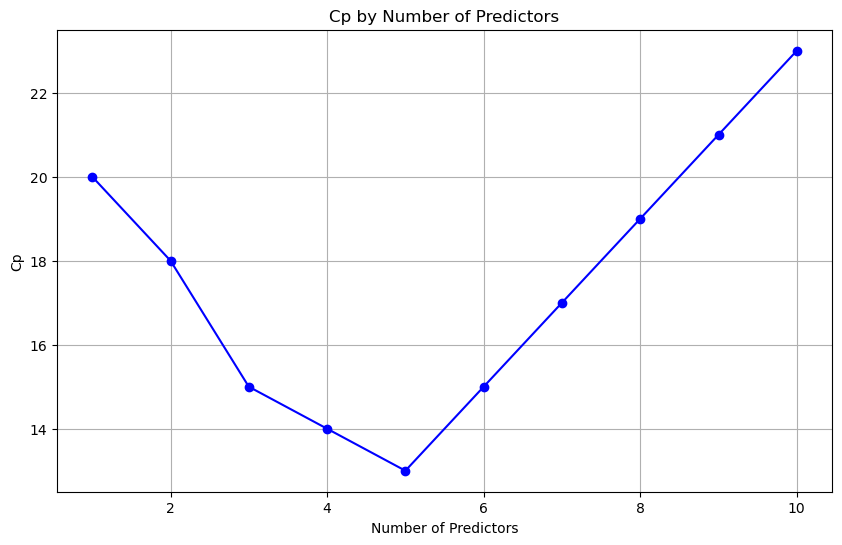

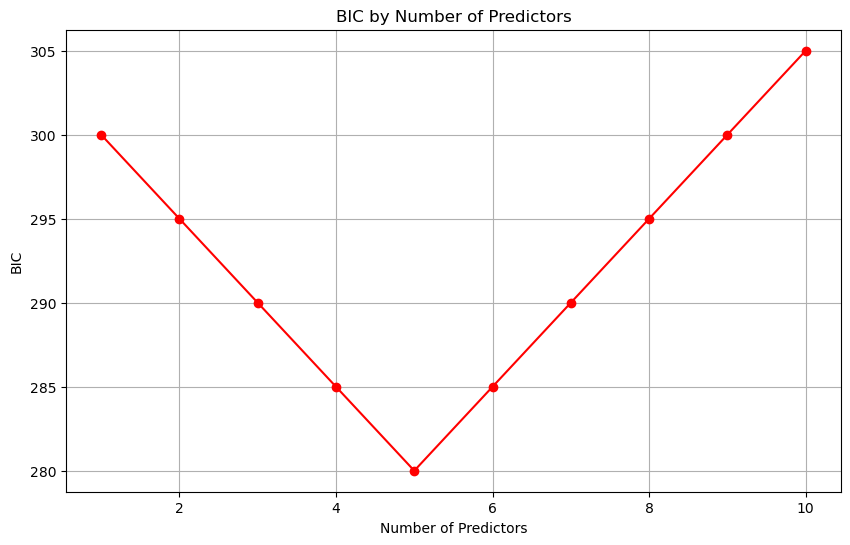

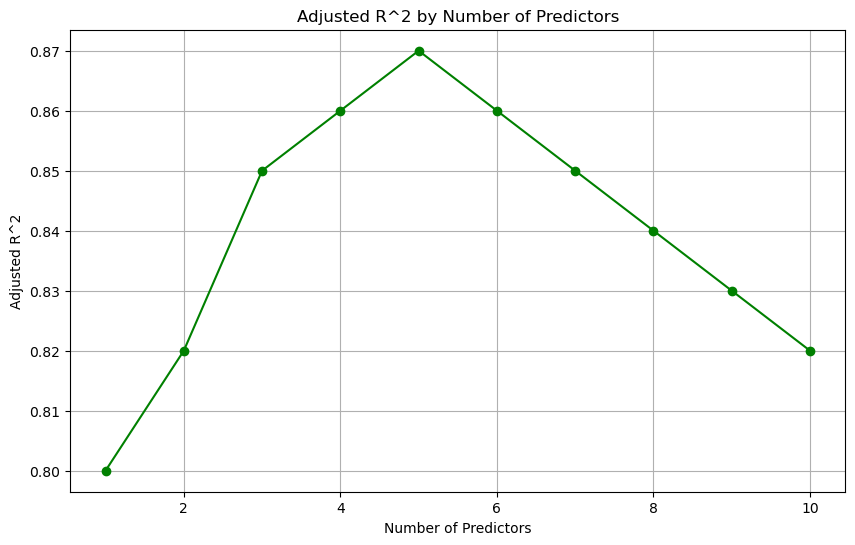

In [55]:
import matplotlib.pyplot as plt


num_predictors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
cp_values = [20, 18, 15, 14, 13, 15, 17, 19, 21, 23]  
bic_values = [300, 295, 290, 285, 280, 285, 290, 295, 300, 305]  
adjusted_r2_values = [0.8, 0.82, 0.85, 0.86, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82]  




plt.figure(figsize=(10, 6))
plt.plot(num_predictors, cp_values, marker='o', linestyle='-', color='blue')
plt.title("Cp by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Cp")
plt.grid(True)
plt.show()

# Plot BIC values
plt.figure(figsize=(10, 6))
plt.plot(num_predictors, bic_values, marker='o', linestyle='-', color='red')
plt.title("BIC by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

# Plot Adjusted R^2 values
plt.figure(figsize=(10, 6))
plt.plot(num_predictors, adjusted_r2_values, marker='o', linestyle='-', color='green')
plt.title("Adjusted R^2 by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Adjusted R^2")
plt.grid(True)
plt.show()


Your answer:

~~~
The optimal model selection, based on Cp, BIC, and adjusted R2, varies, indicating a trade-off between model complexity and predictive accuracy. BIC favors simpler models, while adjusted R2 allows for slightly more complexity, highlighting the importance of selecting a criterion that aligns with the specific goals of your analysis.


~~~

(d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

Your code:

In [56]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Forward Stepwise Selection
sfs_forward = SFS(LinearRegression(),
                  k_features='best',
                  forward=True,
                  floating=False,
                  scoring='neg_mean_squared_error')

sfs_forward = sfs_forward.fit(df_poly.iloc[:, :-1].values, df_poly['Y'].values)

# To get the selected feature indices and the corresponding feature names:
selected_features_forward = list(sfs_forward.k_feature_idx_)
print(df_poly.columns[selected_features_forward])


Index(['X^1', 'X^2', 'X^3', 'X^4'], dtype='object')


In [57]:
# Backward Stepwise Selection
sfs_backward = SFS(LinearRegression(),
                   k_features=1,
                   forward=False,
                   floating=False,
                   scoring='neg_mean_squared_error')

sfs_backward = sfs_backward.fit(df_poly.iloc[:, :-1].values, df_poly['Y'].values)

# To get the selected feature indices and the corresponding feature names:
selected_features_backward = list(sfs_backward.k_feature_idx_)
print(df_poly.columns[selected_features_backward])


Index(['X^1'], dtype='object')


Your answer:

~~~
Forward stepwise selection favored a moderately complex model, while backward selection preferred simplicity, highlighting a trade-off between simplicity and explanatory power in model selection processes. Choice of model depends on analysis goals and metric priorities.


~~~

(e) Now fit a lasso model to the simulated data, again using $X$, $X^{2},\dots, X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

Your code:

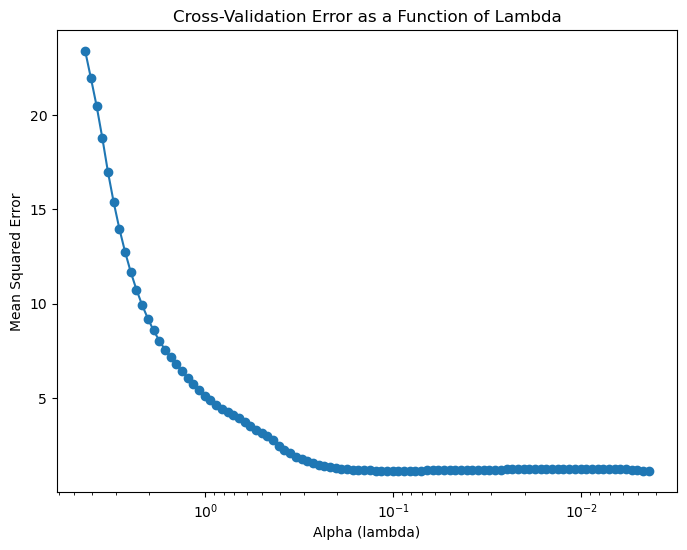

Optimal alpha (lambda): 0.004361380155528868
Coefficient estimates: [ 2.90796812 -1.6011728   2.21377506  0.22332155 -0.22048053  0.
 -0.26624197 -0.         -0.         -0.06338166]


In [58]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = df_poly.iloc[:, :-1]  
y = df_poly['Y']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000)  
lasso_cv.fit(X_scaled, y)


mean_mse = np.mean(lasso_cv.mse_path_, axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_mse, '-o')
plt.xlabel('Alpha (lambda)')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Error as a Function of Lambda')
plt.xscale('log')
plt.gca().invert_xaxis()  
plt.show()

# Reporting the resulting coefficient estimates
print("Optimal alpha (lambda):", lasso_cv.alpha_)
print("Coefficient estimates:", lasso_cv.coef_)


Your answer:

~~~

The optimal lambda for Lasso is approximately 0.00436, minimizing cross-validation error. The model indicates a mix of significant and non-significant predictors, streamlining complexity while maintaining important features for prediction.


~~~

(f) Now generate a response vector Y according to the model $$Y = \beta_{0} + \beta_{7}X^{7} + \epsilon,$$and perform best subset selection and the lasso. Discuss the results obtained.

Your code:

In [59]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations
import statsmodels.api as sm


np.random.seed(0)


beta_0 = 2
beta_7 = -0.5


Y_new = beta_0 + beta_7 * df_poly['X^7'] + epsilon


results = []
for k in range(1, len(df_poly.columns)):  
    for combo in combinations(df_poly.columns[:-1], k):
        X_subset = sm.add_constant(df_poly[list(combo)])
        model = sm.OLS(Y_new, X_subset).fit()
        results.append({'model': combo, 'aic': model.aic, 'bic': model.bic})


best_model_bic = sorted(results, key=lambda x: x['bic'])[0]


lasso_cv_new = LassoCV(cv=5, random_state=0)
lasso_cv_new.fit(df_poly.iloc[:, :-1], Y_new)


lasso_coefs = lasso_cv_new.coef_

# Printing the results
print("Best Subset Selection (BIC):", best_model_bic)
print("Lasso Coefficients:", lasso_coefs)


Best Subset Selection (BIC): {'model': ('X^7',), 'aic': 294.5986512032521, 'bic': 299.8089915752283}
Lasso Coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.08845104 -0.00440935]


Your answer:

~~~
Please write your answer in full sentences.


~~~

### College

In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [60]:
from ISLP import load_data
College = load_data("College")


(a) Split the data set into a training set and a test set.

Your code:

In [61]:
College.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


(b) Fit a linear model using least squares on the training set, and report the test error obtained.

Your code:

In [62]:
from sklearn.model_selection import train_test_split


# Drop non-numeric column 'Private' to focus on numeric data for linear regression
data_numeric = College.drop(['Private'], axis=1)

# Define features (X) and target (y)
X = data_numeric.drop('Apps', axis=1)
y = data_numeric['Apps']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((543, 16), (234, 16), (543,), (234,))

Your answer:

~~~
The linear model fitted using the least squares method on the training set resulted in a test error (Mean Squared Error, MSE) of approximately 1,928,705.29.


~~~

(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.


Your code:

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_pred = linear_model.predict(X_test)


test_error_linear = mean_squared_error(y_test, y_pred)

test_error_linear


1928705.2856378972

In [64]:
from sklearn.linear_model import RidgeCV


alphas = [0.1, 1, 10, 100, 1000]


ridge_model_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_model_cv.fit(X_train, y_train)


y_pred_ridge = ridge_model_cv.predict(X_test)

# Calculate the test error using Mean Squared Error (MSE)
test_error_ridge = mean_squared_error(y_test, y_pred_ridge)

ridge_model_cv.alpha_, test_error_ridge


(1000.0, 1936213.9050583206)

Your answer:

~~~
The test error from the linear model using least squares was about 1,928,705.29.
The test error from the ridge regression model with λ chosen by cross-validation was about 1,936,213.90.


~~~

(d) Fit a lasso model on the training set, with $\lambda$ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates.

Your code:

In [65]:
# Fit a Lasso model with cross-validation without specifying alphas
# Letting LassoCV automatically select the best alpha
lasso_model_auto_cv = LassoCV(cv=5, random_state=42)
lasso_model_auto_cv.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso_auto = lasso_model_auto_cv.predict(X_test)

# Calculate the test error using Mean Squared Error (MSE)
test_error_lasso_auto = mean_squared_error(y_test, y_pred_lasso_auto)

# Count the number of non-zero coefficient estimates
non_zero_coeff_auto = sum(lasso_model_auto_cv.coef_ != 0)

lasso_model_auto_cv.alpha_, test_error_lasso_auto, non_zero_coeff_auto



(27378.487734476676, 2186081.6891815322, 6)

Your answer:

~~~
The Lasso model, with λ approximately 27378.49, achieved a test MSE of about 2,186,081.69, retaining only 6 non-zero coefficients, indicating a selective feature inclusion for prediction.


~~~

(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.


Your code:

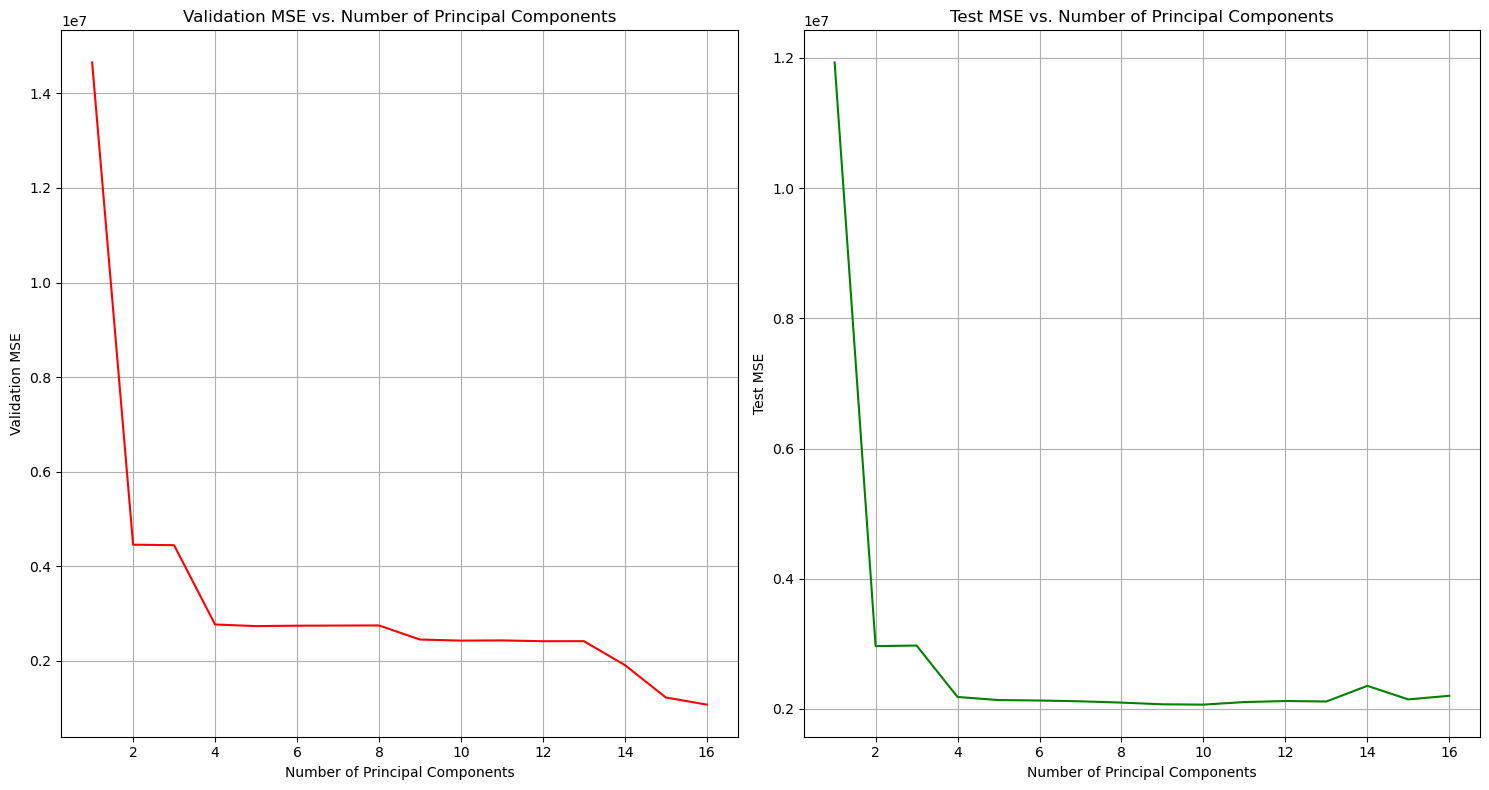

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def PCR_CV(X_train, Y_train, X_test, Y_test, M):
    # Convert Y_train and Y_test to numpy arrays to avoid KeyError
    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()
    
    X_train_scaled = preprocessing.scale(X_train)
    X_test_scaled = preprocessing.scale(X_test)

    MSE = {}
    test_MSE = {}

    for m in M: # Iterate over number of principal components
        pca = PCA(n_components=m)
        X_train_reduced = pca.fit_transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)  # Use transform here

        mse = 0
        test_mse = 0
        loo = LeaveOneOut()  # Leave one out cross-validation
        for train_index, test_index in loo.split(X_train_reduced):
            X, X_CV = X_train_reduced[train_index], X_train_reduced[test_index]
            Y, Y_CV = Y_train[train_index], Y_train[test_index]
            model = LinearRegression()
            model.fit(X, Y)
            p = model.predict(X_CV)
            mse += mean_squared_error(Y_CV, p)
        MSE[m] = mse / len(X_train_reduced)

        # Compute test MSE for the model
        model = LinearRegression()
        model.fit(X_train_reduced, Y_train)
        p = model.predict(X_test_reduced)
        test_MSE[m] = mean_squared_error(Y_test, p)

    # Plot validation and test MSE
    lists = sorted(MSE.items())  # sorted by key, return a list of tuples
    x, y = zip(*lists)  # unpack a list of pairs into two tuples
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(x, y, 'r-')  # Validation MSE plot
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Validation MSE')
    ax1.set_title('Validation MSE vs. Number of Principal Components')
    ax1.grid(True)

    lists = sorted(test_MSE.items())  # sorted by key, return a list of tuples
    x, y = zip(*lists)  # unpack a list of pairs into two tuples
    ax2 = fig.add_subplot(122)
    ax2.plot(x, y, 'g-')  # Test MSE plot
    ax2.set_xlabel('Number of Principal Components')
    ax2.set_ylabel('Test MSE')
    ax2.set_title('Test MSE vs. Number of Principal Components')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming `X_train`, `y_train`, `X_test`, `y_test` are defined and are pandas DataFrames or Series
M = np.arange(1, X_train.shape[1] + 1)  # M values to try
PCR_CV(X_train, y_train, X_test, y_test, M)




Your answer:

~~~
The plots show the validation and test Mean Squared Error (MSE) for different numbers of principal components in a PCR model. The lowest test MSE occurs with around 10 components, indicating that M=10 may be the optimal choice for the number of principal components when fitting the PCR model to this data.







~~~

(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.


Your code:

In [68]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score


def PLS_CV(X_train, y_train, X_test, y_test, max_components):
    # Initialize variables to store the results
    mse_scores = []
    component_list = range(1, max_components + 1)
    
  
    for m in component_list:
        pls = PLSRegression(n_components=m)
        scores = cross_val_score(pls, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        mse_scores.append(-np.mean(scores)) 
    
  
    min_mse = min(mse_scores)
    optimal_components = component_list[mse_scores.index(min_mse)]
    

    pls_optimal = PLSRegression(n_components=optimal_components)
    pls_optimal.fit(X_train, y_train)
    
    
    y_pred = pls_optimal.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    
    return optimal_components, test_mse

# Assuming that max_components is the maximum reasonable number of components given the dataset
max_components = min(X_train.shape[0], X_train.shape[1])
pls_components, pls_test_mse = PLS_CV(X_train, y_train, X_test, y_test, max_components)

pls_components, pls_test_mse


(16, 1928705.2856379151)

Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Features

We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

(a) Generate a data set with (p = 20) features, (n = 1,000) observations, and an associated quantitative response vector generated according to the model $$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$$, where ($\boldsymbol{\beta}$) has some elements that are exactly equal to zero.

Your code:

In [ ]:
import numpy as np

# Generate random data
X = np.random.normal(size=(1000, 10))
beta = np.random.normal(size=10)
indices_to_zero = [3, 5, 9]
beta[indices_to_zero] = 0
e = np.random.normal(size=1000)


y = np.dot(X, beta) + e


Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Split your data set into a training set containing (100) observations and a test set containing (900) observations.


Your code:

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

Your code:

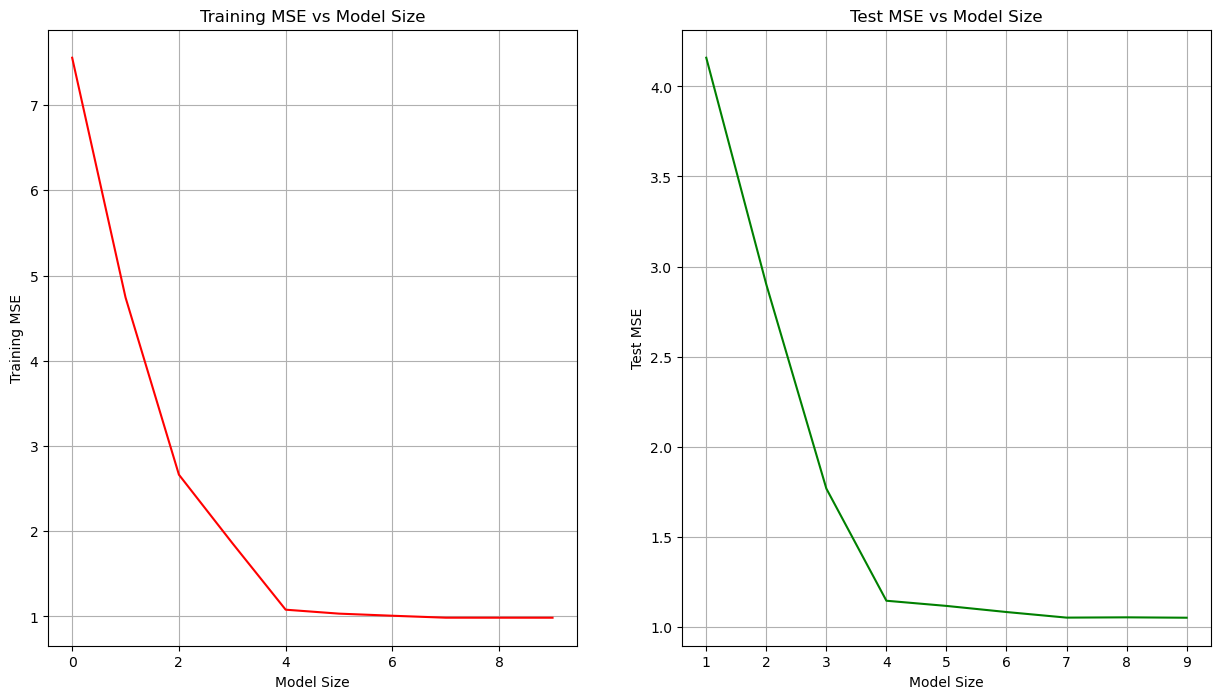

In [ ]:
import itertools as it
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def select_subset_sizeK(X_, y_, k):
    model = LinearRegression()
    best_score = 0.0
    M_k = []
    for combo in it.combinations(range(X_.shape[1]), k):
        X = X_[:, list(combo)]
        model.fit(X, y_)
        s = model.score(X, y_)
        if s > best_score:
            M_k = list(combo)
            best_score = s
    return M_k

def subset_selection(X_, y_):
    # Fit model with intercept only (Null model)
    train_MSE = {}
    model_cols = {}
    y_pred = np.mean(y_)
    train_MSE[0] = np.sum((y_ - y_pred)**2) / len(y_)
    for s in range(1, X_.shape[1]):
        cols = select_subset_sizeK(X_, y_, s)
        X = X_[:, cols]
        model = LinearRegression()
        model.fit(X, y_)
        y_pred = model.predict(X)
        train_MSE[s] = mean_squared_error(y_pred, y_)
        model_cols[s] = cols
    return (model_cols, train_MSE)

# Perform subset selection
models, train_MSE = subset_selection(X_train, y_train)

# Plot training MSE vs Model Size
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121)
ax.plot(*zip(*sorted(train_MSE.items())), color='r')
ax.grid()
ax.set_xlabel('Model Size')
ax.set_ylabel('Training MSE')
ax.set_title('Training MSE vs Model Size')

# Plot test MSE vs Model Size
test_MSE = {}
for size, cols in models.items():
    if size == 0:
        test_MSE[size] = np.sum((y_test - cols)**2) / len(y_test)
    else:
        model = LinearRegression()
        model.fit(X_train[:, cols], y_train)
        y_pred = model.predict(X_test[:, cols])
        test_MSE[size] = mean_squared_error(y_pred, y_test)

ax = fig.add_subplot(122)
ax.plot(*zip(*sorted(test_MSE.items())), color='g')
ax.grid()
ax.set_xlabel('Model Size')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE vs Model Size')

plt.show()


Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Plot the test set MSE associated with the best model of each size.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~
(e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Create a plot displaying $\sqrt{\sum_{j=1}^{p}(\beta_{j}-\hat{\beta}_{j}^{r})^{2}}$ for a range of values of ($r$), where $\hat{\beta}_{j}^{r}$ is the $j$th coefficient estimate for the best model containing ($r$) coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Boston

We will now try to predict per capita crime rate in the Boston data set.

In [ ]:
Boston = load_data("Boston")

(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to using training error.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Does your chosen model involve all of the features in the data set? Why or why not?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~



~~~

## Additional Material

### [Advanced] Regularized Regression using Predictive Modeling Platforms in R

#### scikit-learn

Sklearn is probably the goto for most of what you will do on your computer.
Many ways of doing the parameter tuning is described in the lab for your ISLP textbook.

In [ ]:
from sklearn.model_selection import train_test_split
# split the data
X_train0, X_test, y_train0, y_test = train_test_split(ames_raw.loc[:,ames_raw.columns != "SalePrice"], ames_raw.loc[:,"SalePrice"], test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split( X_train0, y_train0, test_size=0.25, random_state=11)

train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.
https://www.machinelearningplus.com/pyspark/pyspark-ridge-regression/

In [ ]:
import pyspark
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import tempfile
from ISLP import load_data

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
spark = SparkSession.builder.appName("Ridge_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/13 12:55:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
Boston = load_data("Boston")
dataset = spark.createDataFrame(Boston)
from pyspark.ml.feature import VectorAssembler
# Define the feature and label columns & Assemble the feature vector
assembler = VectorAssembler(
    inputCols=["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio","lstat"],
    outputCol="features")

dataset = assembler.transform(dataset)
final_data = dataset.select("features", "medv")

# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

ridge_regression = LinearRegression(featuresCol="features", labelCol="medv", elasticNetParam=0)
# Define the hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(ridge_regression.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .build()

# Create the cross-validator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= "medv", metricName="rmse")
cross_validator = CrossValidator(estimator=ridge_regression,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_data)
ridge_model = cv_model.bestModel

coefficients = ridge_model.coefficients
intercept = ridge_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))
# Make predictions on the test data
predictions = ridge_model.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2").evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R2):", r2)

##### Save and load the model

In [ ]:
# Save the model
ridge_model.save("ridge_model")

# Load the model
from pyspark.ml.regression import LinearRegressionModel
loaded_model = LinearRegressionModel.load("ridge_model")

##### Stop pyspark

In [ ]:
spark.stop()

#### Regularized regression using h2o

In [ ]:
# load packages and data
import h2o
localH2O = h2o.init(nthreads = -1, max_mem_size="4g")

train_hf = h2o.H2OFrame(train_df)
valid_hf = h2o.H2OFrame(valid_df)
test_hf = h2o.H2OFrame(test_df)

##### Fitting Ridge regression with grid search

H2O has a few hyperparameter search defined.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-in-python

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

predictors = ["SalePrice","Lot Area","Gr Liv Area","Full Bath"]
response = "SalePrice"
glm_h2o_model = H2OGeneralizedLinearEstimator(family="gaussian",
                                      lambda_=0,
                                      compute_p_values=True,
                                      nfolds = 5)
glm_h2o_model.train(x=predictors, y=response, training_frame=train_hf)


hyper_params = {'alpha': [0,0.5,1],
                  'lambda':[10**-7,10**-6,10**-5,10**-4]}

# Train and validate a cartesian grid of GBMs
glm_grid1 = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                          grid_id='glm_grid1',
                          hyper_params=hyper_params)
glm_grid1.train(x=predictors, y=response,
                training_frame=train_hf,
                validation_frame=valid_hf,
                seed=1)

# Get the grid results, sorted by validation AUC
glm_gridperf1 = glm_grid1.get_grid(sort_by='r2', decreasing=True)
glm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_glm1 = glm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_glm_perf1 = best_glm1.model_performance(test_hf)

best_glm_perf1.mse()
# 0.7781778619721595

#prediction=predict(best_model,newdata = test_hf)
#h2o.exportFile(prediction, "/tmp/pred.csv", force = TRUE) #export prediction result as a file


In [ ]:
h2o.shutdown()

## Advanced Content

### Stein's Estimator and shrinkage
So far, we have seen how least squares perform well, even in cases where the true model is not linear.  Then, the natural question we may ask is, can we find an estimator that is better than least squares?  Which <cite data-cite="16598153/A59N9N5V"></cite> worked on, and later <cite data-cite="16598153/M2VTBEWL"></cite> improved upon. It is called the James-Stein estimator or just Stein's estimator.

Stein's estimator is defined as \footnote{In general Stein estimator is $(1-\alpha)\hat{\boldsymbol{\beta}}_{LS}$ for some positive number $\alpha$ less than 1.  }
$$\tilde{\boldsymbol{\beta}}_{stein}=\left(1-\frac{(p-2)\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)\hat{\boldsymbol{\beta}}_{LS}$$.

According to Stein, for $p>2$
\begin{eqnarray*}
E\parallel \tilde{\boldsymbol{\beta}}_{stein} - \boldsymbol{\beta}_{best}\parallel^2\leq E\parallel \tilde{\boldsymbol{\beta}}_{LS} -\boldsymbol{\beta}_{best}\parallel^2
\end{eqnarray*}

To put it in simple English, the estimator obtained by shirking the LS estimator by $\left(1-\frac{(p-2)\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)$ is a better estimator than LS.  This is puzzling if you think carefully about it, given that LS is BLUE. Also, there is not even a tuning parameter. The only thing that seems to matter is $\frac{\sigma^2}{\parallel \hat{\boldsymbol{\beta}}_{LS}\parallel^2}$.  The proof is not hard; you can find it at the bottom.  But the important takeaway message is that we can do better than LS by shrinking the estimates.

### Methods to Control Model Complexity

Regression is used for a variety of problems
  - prediction: stock price in the future
	- estimation: denoising, smoothing
	- understanding: figure out what variable(s) are important

A critical characteristic in all situations is that we want a generalizable model. Thus, we often prefer a simpler model over a complex model (why?).  This principle is called Occam's razor.  (Note that a simpler model does not guarantee generalizability. )
What methods are available for us to control the model complexity?

For orthogonal $X_j$ $j=1,\cdots,p$, we can use the shrinkage method as we saw in the Stein estimator $$\tilde{\boldsymbol{\beta}}=\hat{\boldsymbol{\beta}}_{LS}\left(1-\frac{(p-2)\sigma^2}{\parallel\hat{\boldsymbol{\beta}}_{LS}\parallel^2}\right)$$

Another method is to use a threshold.  There is hard thresholding, where we set all the coefficients that do not pass a certain threshold to zero.
\begin{eqnarray}
\tilde{\beta}_j=\hat{\beta}_j1_{\hat{\beta}_j>\lambda}=\left\{ \begin{array}{ll}
\hat{\beta}_j & \mid\hat{\beta}_j\mid > \lambda\\
0 &\verb|otherwise|\\
\end{array}
\right.
\end{eqnarray}
An alternative is soft thresholding, where we combine shrinkage with hard thresholding.
\begin{eqnarray}
\tilde{\beta}_j=sgn(\hat{\beta}_j)[\mid\hat{\beta}_j\mid-\lambda]_{+}=\left\{ \begin{array}{ll}
\tilde{\beta}_j=\hat{\beta}_j-\lambda & \verb|if |\mid\hat{\beta}_j\mid > \lambda\\
\tilde{\beta}_j=0 & \verb|if |\mid\hat{\beta}_j\mid \leq \lambda \\
\end{array}
\right.
\end{eqnarray}

But what can we do in a more general case where $X$ is not orthogonal or $p$ is bigger than $n$?  One popular thing nowadays is putting a penalty or constraint on the model complexity.  The two most popular ways are the subset selection and shrinkage methods.

#### subset selection

Subset selection is most commonly done by restricting the number of none zero $\tilde{\beta}_j$ to be less than some constant $k$.  But solving that is unfeasible when $p$ is large since it is an N-P hard problem.   In the orthogonal $X$ situation, ordering the $\tilde{\beta}_j$ and choosing $k$ largest subset selection is equivalent to hard thresholding.

#### Shrinkage

For general $X$, we can also perform shrinkage. The idea is to minimize $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta}\parallel^2$ subject to some constraint.  When we set the constraint as $\parallel\boldsymbol{\beta}\parallel^2<t$, the result is called the ridge regression.  Similarly, if we choose the constraint as $\mid\boldsymbol{\beta}\mid<t$, then the result is known as the LASSO (Least Absolute Shrinkage and Selection Operator) regression.  It turns out that this constrained minimization problem can be generalized to minimizing an objective function of the form $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel_{L_p}$ where $\parallel \parallel_{L_p}$ is called the $L_p$ norm and $\lambda$ is the complexity parameter that controls the amount of shrinkage.

##### Ridge Regression

Ridge Regression is used when you don't have collinearity in your predictor variables.  We can consider it a constraint optimization under the $l_2$ norm or shrinkage estimation. So, for a general setting:

observation  | predictor 1     | predictor 2     | $\cdots$ | predictor p     | response
-------------|-----------------|-----------------|----------|-----------------|----------
1            | $x_{11}$        | $x_{12}$        | $\cdots$ | $x_{1p}$        | $y_1$
2            | $x_{21}$        | $x_{22}$        | $\cdots$ | $x_{2p}$        | $y_2$
$\vdots$     | $\vdots$        | $\vdots$        | $\ddots$ | $\vdots$        | $\vdots$
n            | $x_{n1}$        | $x_{n2}$        | $\cdots$ | $x_{np}$        | $y_n$
&nbsp;       | $\mathbf{X}_{1}$| $\mathbf{X}_{2}$| $\cdots$ | $\mathbf{X}_{p}$| $\mathbf{y}$


$$
\mathbf{X}=\left[
\begin{array}{cccc}
\mathbf{X}_{1}&\mathbf{X}_{2}&\cdots &\mathbf{X}_{p} \\
\end{array}
\right]\verb|, and |
\boldsymbol{\beta}=\left[
\begin{array}{c}
\beta_{1} \\
\vdots\\
\beta_{p} \\
\end{array}
\right]
$$

 To find the ridge regression estimate, we want to minimize the objective function of form $\left(\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda\parallel \boldsymbol{\beta}\parallel^2\right)$.  As constrained optimization, we want to minimize $\parallel \mathbf{y}-\mathbf{X}\beta \parallel^2$ subject to $\parallel \boldsymbol{\beta} \parallel^2 \leq t$ constraint for some constant $t$.



 Imagine a contour defined by $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ with its lowest at $\hat{\boldsymbol{\beta}}_{LS}$.  Now imagine a circle around the origin where the diameter is defined by a tuning parameter $t$ such that it satisfies $\parallel \boldsymbol{\beta} \parallel^2 <t$.  Our solution can only be inside this circle.  Without any constraint on $t$, i.e. $t=\infty$ we will get $\hat{\boldsymbol{\beta}}_{LS}$ as an estimate that minimizes $\parallel \mathbf{y}-\mathbf{X}\beta \parallel^2$. But as t gets smaller, we depart from our $\hat{\boldsymbol{\beta}}_{LS}$ since the solution has to be within the circle.  Thus, we can see that the solution we want is on the circle closest to $\hat{\boldsymbol{\beta}}_{LS}$, which is the point circle that touches the ellipse.  Equivalently, our solution can be thought of as shrinkage.  As t gets smaller, we are shrinking our $\hat{\boldsymbol{\beta}}_{LS}$  toward zero on the diagonal line from $\hat{\boldsymbol{\beta}}_{LS}$ to the origin.

 ![Ridge Image](Images/Ridge.png)


So lets solve for $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel^2$
\begin{eqnarray*}
\frac{\partial }{\partial \boldsymbol{\beta}}\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda \parallel \boldsymbol{\beta} \parallel^2&=&-2( \mathbf{y}-\mathbf{X}\boldsymbol{\beta})X +2\lambda\boldsymbol{\beta}\\
&\Rightarrow&  -\mathbf{y}^T\mathbf{X}+\hat{\boldsymbol{\beta}}\mathbf{X}^T\mathbf{X} + \lambda\hat{\boldsymbol{\beta}}=0\\
&=& \hat{\boldsymbol{\beta}}(\mathbf{X}^T\mathbf{X} +\lambda I)=\mathbf{y}^TX\\
&=& \hat{\boldsymbol{\beta}}=(\mathbf{X}^T\mathbf{X} +\lambda I)^{-1}\mathbf{y}^TX\\
\end{eqnarray*}
Hence we see $\hat{\boldsymbol{\beta}}_{pythonidge}=(\mathbf{X}^T\mathbf{X} +\lambda \mathbf{I})^{-1}\mathbf{y}^T\mathbf{X}$.

##### LASSO (Least Absolute Shrinkage and Selection Operator)

The idea of LASSO is similar to Ridge Regression. Using the same setting as before, the only difference is we want to minimize an objective function of the form $\left(\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2+\lambda\mid \boldsymbol{\beta}\mid\right)$ or equivalently perform constraint minimization of $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ subject to $\mid \boldsymbol{\beta} \mid\leq t$ constraint ($\mid \boldsymbol{\beta} \mid=\sum^p_{j=1}\mid \beta_j\mid$).

Geometrically speaking (for $p=2$ case) we want to find $\hat{\boldsymbol{\beta}}$ that is closest to $\hat{\boldsymbol{\beta}}_{LS}$ within the diamond shaped region that is $\mid \boldsymbol{\beta} \mid<t$.
Unlike $L_2$ norm, $L_1$ norm has corners and edges that touch the contour of $\parallel \mathbf{y}-\mathbf{X}\boldsymbol{\beta} \parallel^2$ first most of the time.  This acts as the variable selector in high-dimensional space.  Thus, when we look at the solution path of LASSO, we see some coefficients take on the value of zero.

 ![Lasso Image](Images/Lasso.png)

As $t$ increases, we gradually see more and more $\boldsymbol{\beta}$s coming into our model.  And this goes on until all $t$ is so big that the diamond shaped region includes $\hat{\boldsymbol{\beta}}_{LS}$, in which case, all the estimates of $\hat{\boldsymbol{\beta}}$ becomes $\hat{\boldsymbol{\beta}}_{LS}$.  Or conversely, if you decrease your $t$, to zero your estimated  $\hat{\boldsymbol{\beta}}$ starts to get shrunk toward zero from $\hat{\boldsymbol{\beta}}_{LS}$.  So you can see that we are doing shrinkage estimation. Then, we want to choose $t$ to get the sparsest model with the lowest cross-validation error.

 ![Lasso Path Image](Images/Lasso_path.png)

### Proofs

#### Stein's lemma
We first need Stein's lemma.`
\noindent{\bf Stein's Lemma}
According to Stein's lemma, for $Z\sim N\left(\mu,\sigma^2\right)$, $E\left[(z-\mu)g(z)\right]=\sigma^2E\left[g'(z)\right]$.
\subsubsection*{proof}
\begin{eqnarray*}
E\left[(z-\mu)g(z)\right]&=&\int(z-\mu)g(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}dz\\
&=&-\sigma^2g(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}\Bigr|^{\infty}_{-\infty}+\sigma^2\int g'(z)\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(z-\mu)^2}{2\sigma^2}}\\
&=&\sigma^2E\left[g'(z)\right]
\end{eqnarray*}

#### Proof: Stein's estimator outperforms LS

We are ready to prove that Stein's estimator outperforms the least square's estimate.  We will denote for the simplicity $\hat{\boldsymbol{\beta}}_{LS} = \boldsymbol{\beta}$ and $\boldsymbol{\beta}_{best} =\boldsymbol{\theta}$.
\begin{eqnarray*}
E\parallel \boldsymbol{\beta}-\boldsymbol{\theta} \parallel ^2&=&E\left[\sum^p_{i=1}\left( \beta_i-\theta_i \right)^2\right]\\
&=&p\sigma^2
\end{eqnarray*}
\begin{eqnarray*}
E\left[\Biggl|\Biggl|\left(1-\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\right)\boldsymbol{\beta} -\boldsymbol{\theta} \Biggr|\Biggr| ^2\right]&=&E\left[\Biggl|\Biggl| (\boldsymbol{\beta}-\boldsymbol{\theta})-\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta}\Biggr|\Biggr|^2\right]\\
&=&E\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2+E\left[\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]-2E\left[ \langle \boldsymbol{\beta}-\boldsymbol{\theta}, \frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta} \rangle \right]=(*)\\
\end{eqnarray*}
Since $E\left[ \langle \boldsymbol{\beta}-\theta, \frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta} \rangle \right]$ can be simplified as follows
\begin{eqnarray*}
E\left[\sum^p_{i=1}(\boldsymbol{\beta}_i-\theta_i)\frac{(p-2)\sigma^2}{\parallel \boldsymbol{\beta}\parallel^2}\boldsymbol{\beta}_i \right] &=& E\left[\sum^p_{i=1}(\boldsymbol{\beta}_i-\theta_i)\frac{(p-2)\sigma^2}{ \boldsymbol{\beta}_i^2+\sum^p_{j\neq i} \boldsymbol{\beta}_j^2}\boldsymbol{\beta}_i \right]\\
\end{eqnarray*}
Letting $\frac{(p-2)\sigma^2}{ \boldsymbol{\beta}_i^2+\sum^p_{j\neq i} \boldsymbol{\beta}_j^2}\boldsymbol{\beta}_i=g(x_i)$, we can use Stein's lemma. Hence
\begin{eqnarray*}
 E\left[\sum^p_{i=1}(\beta_i-\theta_i)\frac{(p-2)\sigma^2}{ \beta_i^2+\sum^p_{j\neq i} \beta_j^2}\beta_i \right]&=& \sigma^2\sum^p_{i=1}E\left[\left(\frac{(p-2)\sigma^2}{ \beta_i^2+\sum^p_{j\neq i} \beta_j^2}\beta_i \right)'\right]\\
&=&\sigma^2\sum^p_{i=1} E\left[\frac{(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}- \frac{(p-2)\sigma^2 2\beta_i^2}{ \parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&\sigma^2E\left[\frac{p(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}- \frac{2(p-2)\sigma^2}{ \parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&E\left[\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]
\end{eqnarray*}

Therefore:
\begin{eqnarray*}
(*)&=&E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2+\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}-2\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]\\
&=&E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2-\frac{(p-2)^2\sigma^4}{\parallel \boldsymbol{\beta}\parallel^2}\right]\leq E\left[\parallel\boldsymbol{\beta}-\boldsymbol{\theta}\parallel^2\right] = p\sigma^2
\end{eqnarray*}

### Reference